In [125]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from reco_systems.filter import filter_df
from reco_systems.user_game_matrix import *

from surprise import NMF
from surprise import Dataset
from surprise.reader import Reader
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

In [126]:
folder = "../database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", index_col=0)

min_reviews = 10 # change to set one

In [356]:
# filter data with the minimum reviews
rev_filter = filter_df(avis_clean, min_reviews)

# create user-game matrix
user_game_ratings, mask_ratings, users_table_assoc, games_table_assoc = get_matrix_user_game(rev_filter)
filter_games_index = pd.merge(rev_filter["Game id"].drop_duplicates(), games_table_assoc.reset_index(), on="Game id")
filter_users_index = pd.merge(rev_filter["User id"].drop_duplicates(), users_table_assoc.reset_index(), on="User id")

filter_games_index.columns = ["Game id", "Game index"]
filter_users_index.columns = ["User id", "User index"]

11201 10549
2252 2676
1957 2618
1947 2616
1946 2615
1945 2614


In [ ]:
users_tags = filter_users_index.merge(jeux_clean, on="User id")[["User id", "Type"]]
users_tags["Type"] = users_tags["Type"].str.split("|")
users_tags = users_tags.explode("Type")
users_tags["Type"] = users_tags["Type"].str.strip().str.lower()
users_tags = users_tags.drop_duplicates()

users_tags = users_tags.pivot_table(index="User id", columns="Type", aggfunc="size", fill_value = 0, dropna=False)


,Game id,User id
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
...,...,...
1940,9509,1940
1941,9583,1941
1942,9596,1942
1943,9701,1943


## Games tags

In [327]:
games_filter = pd.merge(jeux_clean, filter_games_index, on="Game id")
games_exploded = games_filter.copy()
games_exploded["Type"] = games_filter["Type"].str.split('|')

games_exploded = games_exploded.explode("Type")
games_exploded["Type"] = games_exploded["Type"].str.strip().str.lower()
games_exploded = games_exploded.drop_duplicates()

games_tags = games_exploded.pivot_table(index="Game id", columns="Type", aggfunc='size', fill_value=0, dropna=False)

## Delete rare tags

In [328]:
tags_freq = pd.DataFrame(index=games_tags.columns)
tags_freq["Sum"] = games_tags.apply(sum, axis=0)
tags_freq = tags_freq.reset_index().sort_values(by="Sum", ascending=False)
tags_freq[tags_freq["Type"] == "alignement"]

# Delete unpopular tags
tags_filter = tags_freq[tags_freq["Sum"] >= 20]
games_tags = games_tags.loc[:, tags_filter["Type"].values]
users_tags = users_tags.loc[:, tags_filter["Type"].values]
games_tags.shape, tags_filter.shape, users_tags.shape

((2614, 86), (86, 2), (1945, 86))

Text(0, 0.5, 'Number of games')

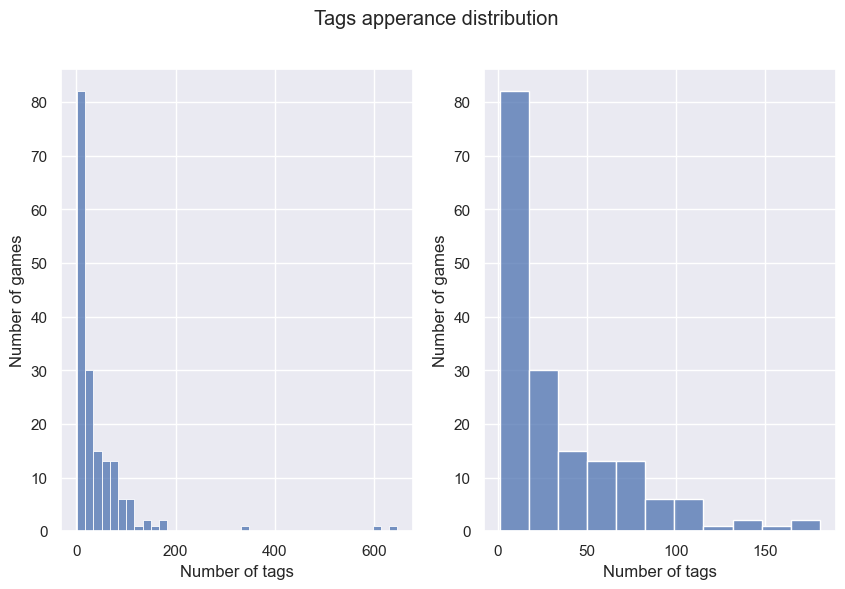

In [329]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
#sns.set_theme(rc={'figure.figsize':(6,4)})
sns.histplot(tags_freq["Sum"], ax=ax1)

tags_limit = tags_freq[tags_freq["Sum"] < 200]
sns.histplot(tags_limit["Sum"], ax=ax2)

plt.suptitle("Tags apperance distribution")
ax1.set_xlabel("Number of tags")
ax2.set_xlabel("Number of tags")

ax1.set_ylabel("Number of games")
ax2.set_ylabel("Number of games")


# NNMF

In [330]:
model = NMF(n_factors=30, random_state=42, biased=False, reg_pu= 0.1, reg_qi= 0.1)
data = Dataset.load_from_df(rev_filter[["User id", "Game id", "Rating"]], reader=Reader(rating_scale=(0, 10)))
trainset = data.build_full_trainset()
nmf = model.fit(trainset)

# Extract matrices
U = nmf.pu  # User-feature matrix (W)
G = nmf.qi  # Item-feature matrix (H)
G.shape

(2614, 30)

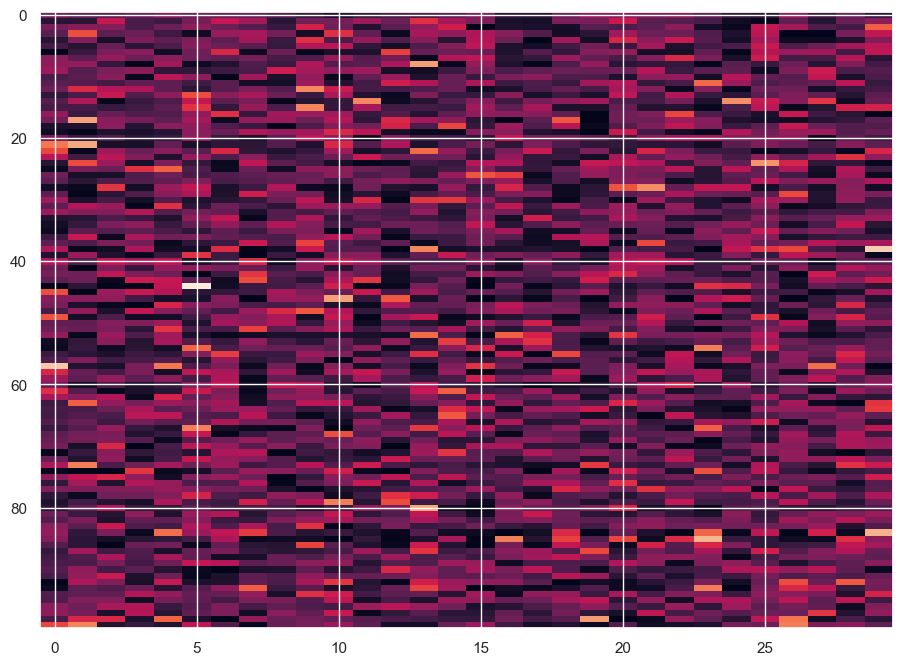

In [129]:
plt.imshow(G[:100, :], aspect="auto")

In [349]:
games_ids = [trainset.to_raw_iid(i) for i in range(len(G))]
users_ids = [trainset.to_raw_uid(u) for u in range(len(U))]
#G[games_ids, :]
len(users_ids)

#games_tags = games_tags.loc[games_ids]
#users_tags = users_tags.loc[users_ids]
users_tags

Type,jeux de plateau,NaN,jeux de cartes,"hasard (dé, cartes, ...)",placement,affrontement,combinaison,gestion,déplacement,médiéval-fantastique,...,draft,pirate,historique,jeu de logique,jeux de dés,pari,créativité,transport de marchandise,lettres / mots,zombies
User id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1940,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1941,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1942,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Games clustering (NNMF profiles based)

([<matplotlib.lines.Line2D at 0x3036d5c10>],
 array([23, 24, 18, 19, 22, 21, 20, 17, 16, 14,  0, 13,  9,  1,  5,  2,  8,
        12,  3, 11, 15,  6,  7,  4, 10]))

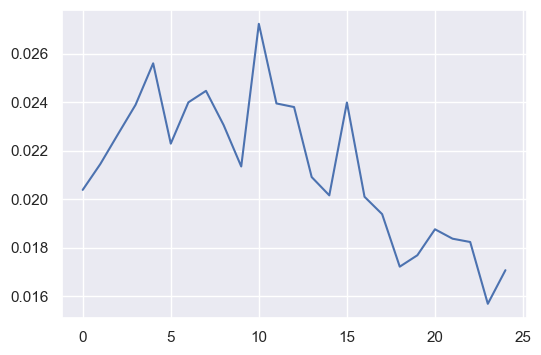

In [283]:
sns.set_theme(rc={"figure.figsize":(6, 4)})
scores = []
for n in range(5, 30):
    kmeans = KMeans(n_clusters=n, random_state=42) 
    kmeans.fit(G) 
    scores.append(silhouette_score(G, kmeans.labels_))

plt.plot(scores), np.argsort(scores)

<Axes: xlabel='Cluster', ylabel='Count'>

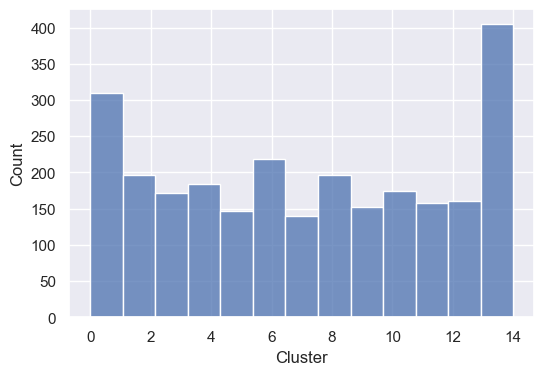

In [286]:
kmeans = KMeans(n_clusters=15, random_state=42) 
kmeans.fit(G) 
game_labels = kmeans.labels_ 

games_clusters = pd.DataFrame(data={"Game id":games_ids, "Cluster":game_labels})

# Distances from centrois
distances = cdist(G, kmeans.cluster_centers_, metric="euclidean")
#games_clusters.merge(distances, left_index=True, left_on=)
distances = pd.DataFrame({"Game id":games_ids, "Distance_centroid": np.take_along_axis(distances, games_clusters["Cluster"].values[..., None], axis=1).flatten()})
games_clusters = games_clusters.merge(distances, on="Game id")
games_clusters
sns.histplot(data=games_clusters["Cluster"])

<Axes: xlabel='Type', ylabel='Cluster'>

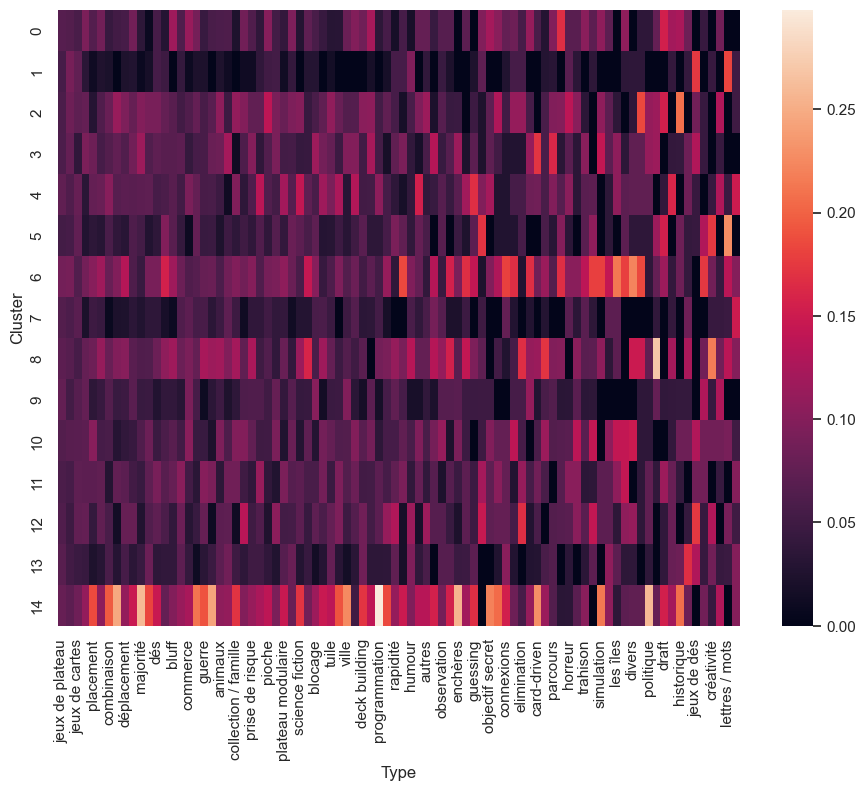

In [158]:
clusters_tags = games_clusters.pivot_table(index="Game id", columns="Cluster", aggfunc='size', fill_value=0).T @ games_tags
clusters_tags_normal = clusters_tags / clusters_tags.sum(axis=0) # normalize
sns.heatmap(clusters_tags_normal)

In [168]:
clusters_tags_df = clusters_tags_normal.stack().to_frame().reset_index()
clusters_tags_df.columns = ["Cluster", "Type", "Frequency"]
#clusters_tags_df.sort_values()
sorted = clusters_tags_df.groupby(by='Cluster', group_keys=False).apply(lambda x: x.sort_values('Frequency', ascending=False).head(10))
clusters_tags_df["Cluster"].unique()

/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_4916/676035316.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sorted = clusters_tags_df.groupby(by='Cluster', group_keys=False).apply(lambda x: x.sort_values('Frequency', ascending=False).head(10))


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int32)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


Text(0.5, 0.98, 'Games clusters')

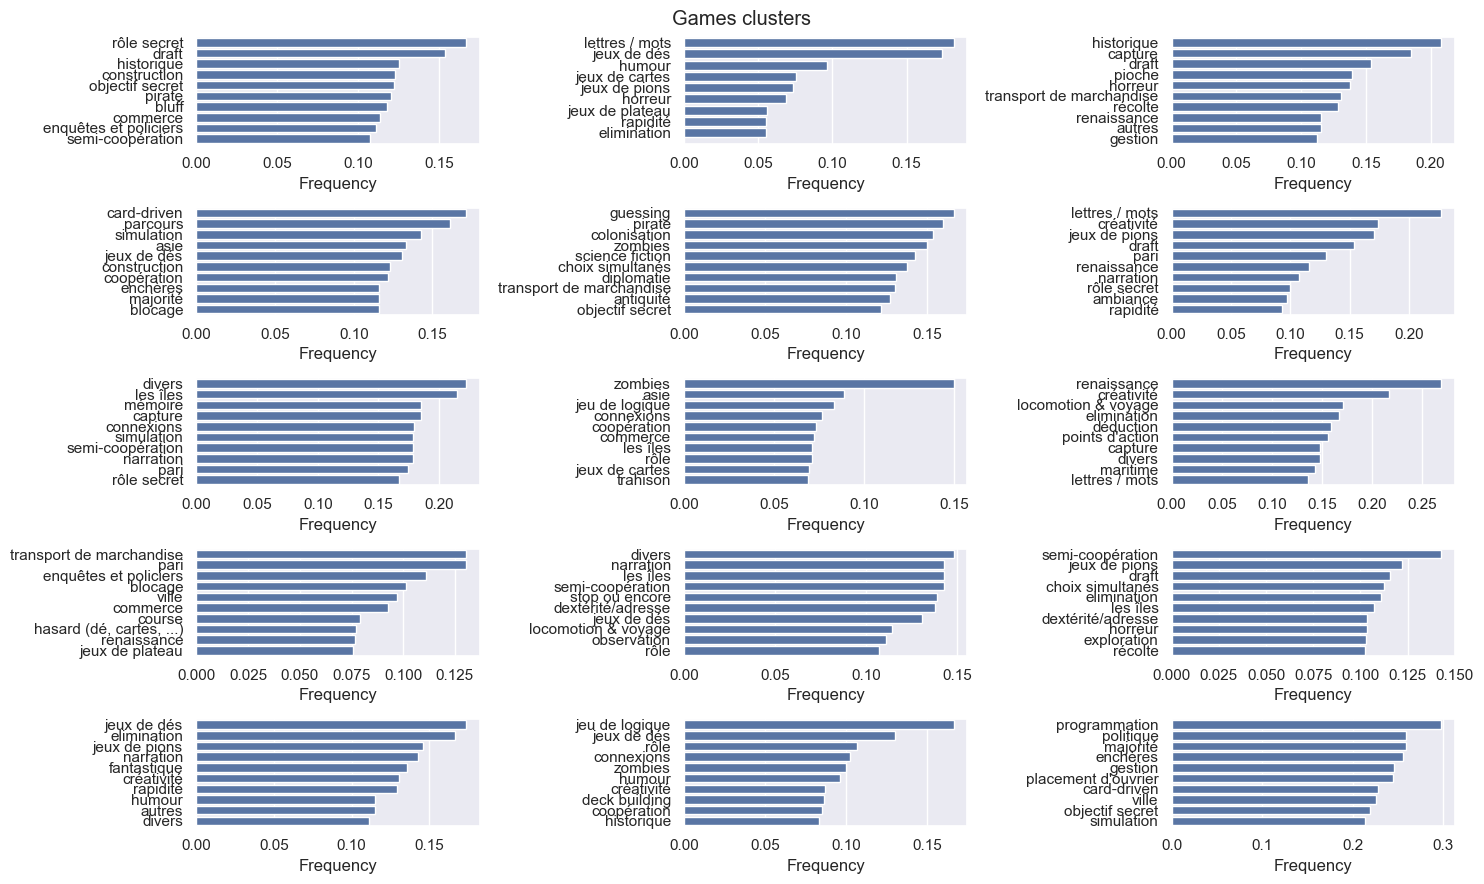

In [171]:
from itertools import product

fig, axes = plt.subplots(5, 3, figsize=(15, 9))
for i, j in product(range(5), range(3)):
    cluster = i * 3 + j
    #if cluster > 6:
        #break
    print(cluster)
    data = sorted[sorted["Cluster"] == cluster]
    bars = sns.barplot(data, y="Type", x="Frequency", ax=axes[i, j])
    bars.set_ylabel("")
    bars.set_yticks(range(10))

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.suptitle("Games clusters")

In [172]:
CD = games_clusters.pivot_table(index="Game id", columns="Cluster", values="Distance_centroid", fill_value=0).T
CS = games_clusters.pivot_table(index="Game id", columns="Cluster", aggfunc='size', fill_value=0).T
CS = CS / CS.sum(axis=0)
clusters_distances = (1 / (CD @ games_tags / CS.sum(axis=1).values[:, None] )).replace(np.inf, 0)
clusters_tags_dist = clusters_distances * clusters_tags / clusters_distances.sum(axis=1).values[:, None]
#clusters_tags_dist = clusters_distances
clusters_tags_dist

Type,jeux de plateau,NaN,jeux de cartes,"hasard (dé, cartes, ...)",placement,affrontement,combinaison,gestion,déplacement,médiéval-fantastique,...,draft,pirate,historique,jeu de logique,jeux de dés,pari,créativité,transport de marchandise,lettres / mots,zombies
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.038697,0.038366,0.038357,0.038687,0.038126,0.037217,0.041035,0.042378,0.038214,0.036579,...,0.044688,0.039465,0.037713,0.034622,0.000000,0.042452,0.000000,0.039623,0.000000,0.000000
1,0.029090,0.028294,0.026441,0.027305,0.023911,0.027538,0.027247,0.000000,0.025367,0.027318,...,0.000000,0.022664,0.000000,0.040153,0.026222,0.000000,0.030525,0.000000,0.031019,0.038885
2,0.040449,0.041324,0.035566,0.041208,0.045971,0.039452,0.041973,0.043791,0.045871,0.041152,...,0.045389,0.000000,0.041614,0.000000,0.042114,0.035778,0.000000,0.044823,0.000000,0.051633
3,0.029422,0.030104,0.026695,0.030959,0.033730,0.030778,0.033802,0.032269,0.028108,0.031497,...,0.000000,0.031708,0.023510,0.023218,0.033836,0.035949,0.000000,0.036802,0.000000,0.000000
4,0.031264,0.032767,0.027818,0.029455,0.037042,0.032361,0.032903,0.036622,0.033324,0.033472,...,0.030412,0.033640,0.000000,0.029744,0.027995,0.000000,0.034889,0.039672,0.035190,0.027645
5,0.034365,0.031641,0.033185,0.027937,0.030151,0.031465,0.036860,0.037482,0.032471,0.031248,...,0.031394,0.000000,0.034131,0.034168,0.027868,0.029423,0.029886,0.000000,0.029618,0.000000
6,0.043295,0.042361,0.043231,0.042975,0.045514,0.043395,0.045197,0.046361,0.042649,0.044673,...,0.046528,0.054885,0.053735,0.042830,0.000000,0.043517,0.049956,0.035940,0.054835,0.038023
7,0.029554,0.031797,0.029829,0.030515,0.033009,0.029800,0.037632,0.024252,0.033121,0.026367,...,0.000000,0.030255,0.000000,0.028323,0.000000,0.000000,0.031755,0.028966,0.034561,0.029632
8,0.047929,0.051997,0.049252,0.052177,0.055096,0.053384,0.051279,0.054741,0.055064,0.052828,...,0.000000,0.049836,0.000000,0.047494,0.000000,0.047055,0.049459,0.049991,0.059116,0.046981


In [176]:
clusters_tags_df = clusters_tags_dist.stack().to_frame().reset_index()
clusters_tags_df.columns = ["Cluster", "Type", "Weight"]
#clusters_tags_df.sort_values()
sorted = clusters_tags_df.groupby(by='Cluster', group_keys=False).apply(lambda x: x.sort_values('Weight', ascending=False).head(10))
sorted[sorted["Cluster"] == 2]

/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_4916/3860701259.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sorted = clusters_tags_df.groupby(by='Cluster', group_keys=False).apply(lambda x: x.sort_values('Weight', ascending=False).head(10))


,Cluster,Type,Weight
234,2,parcours,0.052650
257,2,zombies,0.051633
237,2,dextérité/adresse,0.051350
245,2,capture,0.049423
233,2,locomotion & voyage,0.049050
219,2,asie,0.048886
227,2,récolte,0.048525
204,2,blocage,0.048486
207,2,antiquité,0.048275
200,2,plateau modulaire,0.047055


Text(0.5, 0.98, 'Games clusters (1 / distance from centroid)')

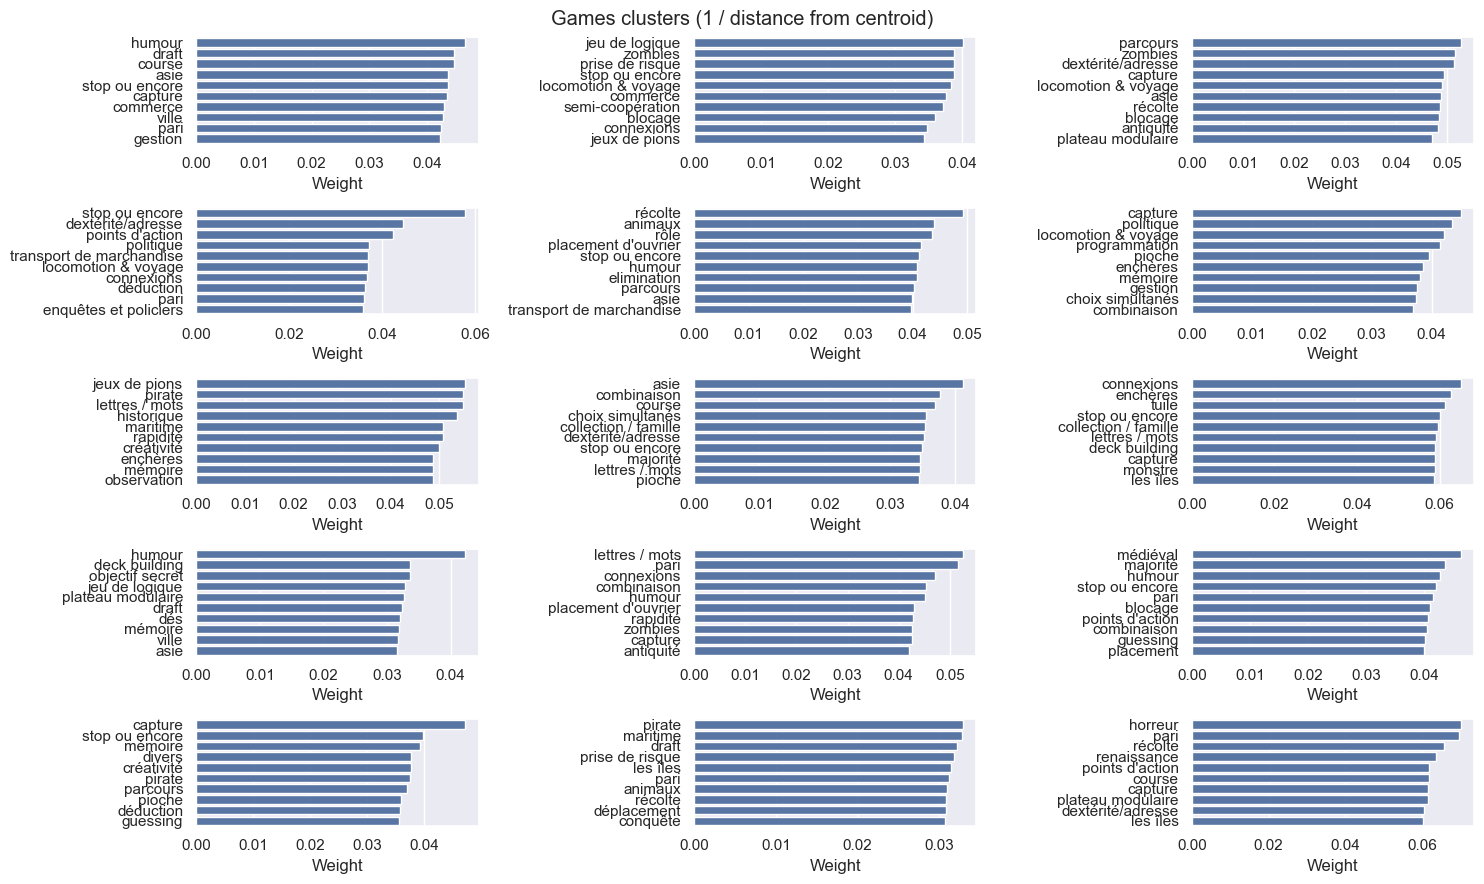

In [177]:
fig, axes = plt.subplots(5, 3, figsize=(15, 9))
for i, j in product(range(5), range(3)):
    cluster = i * 3 + j
    
    data = sorted[sorted["Cluster"] == cluster]
    bars = sns.barplot(data, y="Type", x="Weight", ax=axes[i, j])
    bars.set_ylabel("")
    bars.set_yticks(range(10))

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.suptitle("Games clusters (1 / distance from centroid)")

Text(0.5, 1.0, 'Centroids as latent factors')

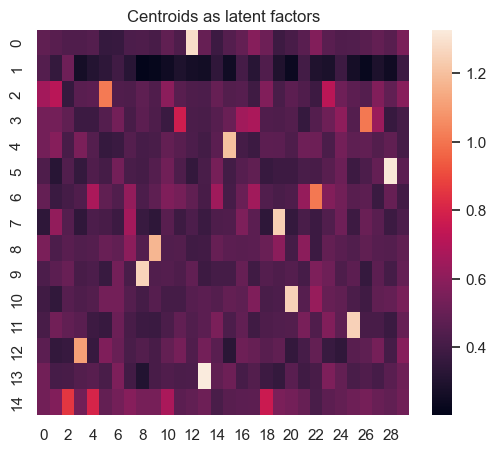

In [222]:
sns.set_theme(rc={"figure.figsize" : (6, 5)})
ax = sns.heatmap(kmeans.cluster_centers_)

ax.set_title("Centroids as latent factors")

| Centroid | Dominant latent factor meaning |
| -------- | ------------------------------ |
| 0        | 12 : narration, pirate, diplomatie |
| 1        |  |
| 2 | 5 : capture, 23 : draft, colonisation, 1 : récolte, politique |
| 3 | 11 : narration, horreur, coopération, 26 : placement d'ouvrier, asie, îles |
| 4 | 15 : enquêtes & policiers |
| 5 | 28 : sémi-coopération, rennaissance |
| 6 | 22 : sémi-coopération |
| 7 | 19 : maritime |
| 8 | 9 : science-fiction |
| 9 | 8 : rennaissance, transport de marchandise |
| 10 | 20 : transport de marchandise |
| 11 | 25 : monstre, maritime |
| 12 | 3 : antiquité, fantastique, gestion de main, deck-building |
| 13 | 13 : points d'action, transport de marchandise, locomotion |
| 14 | 2 : card-driven, enquêtes & policiers, autres, capture |

## Co-occurence matrix

In [185]:
# !!! Important to reorder BEFORE projection
games_tags = games_tags.loc[games_ids]

cooc_matrix = games_tags.T @ games_tags
np.fill_diagonal(cooc_matrix.values, val=0)
cooc_freq = cooc_matrix.apply(sum, axis=1)
cooc_matrix = cooc_matrix.sort_values(by=cooc_matrix.columns.tolist(), ascending=False)
cooc_matrix.iloc[:15, :15]

Type,jeux de plateau,NaN,jeux de cartes,"hasard (dé, cartes, ...)",placement,affrontement,combinaison,gestion,déplacement,médiéval-fantastique,majorité,gestion de main,dés,ambiance,bluff
Type,,,,,,,,,,,,,,,
placement,42,0,8,21,0,17,23,31,19,10,47,17,19,2,10
déplacement,33,0,1,31,19,29,5,18,0,10,10,10,19,7,9
"hasard (dé, cartes, ...)",31,0,17,0,21,39,31,17,31,35,15,25,36,22,14
majorité,28,0,8,15,47,6,17,26,10,9,0,14,4,0,10
commerce,26,0,7,13,21,8,15,35,18,3,11,9,7,3,7
gestion,23,0,1,17,31,12,36,0,18,5,26,15,11,2,4
affrontement,22,0,13,39,17,0,15,12,29,36,6,25,28,15,15
dés,21,0,3,36,19,28,19,11,19,16,4,11,0,9,7
course,21,0,1,11,5,12,3,9,23,3,3,6,15,4,8


<Axes: ylabel='Type'>

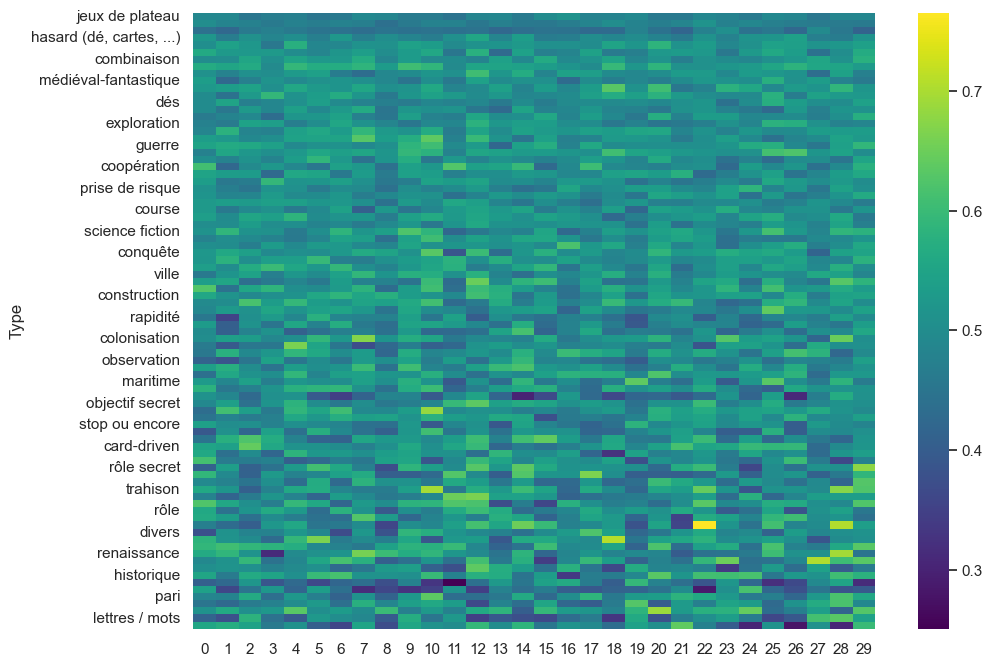

In [186]:
games_count_encode = games_tags / games_tags.sum(axis=0)

games_proj = games_count_encode.T @ G

sns.set_theme(rc={'figure.figsize':(11,8)})
sns.heatmap(games_proj, cmap="viridis")
#plt.grid(False)

In [187]:
games_proj

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
Type,,,,,,,,,,,,,,,,,,,,,
jeux de plateau,0.488250,0.488756,0.452832,0.466045,0.470668,0.450301,0.459573,0.490933,0.483896,0.462592,...,0.458121,0.457949,0.487531,0.477713,0.461353,0.491654,0.484685,0.453952,0.485637,0.486712
NaN,0.500964,0.483718,0.474215,0.461111,0.474011,0.466461,0.477663,0.471119,0.438742,0.460305,...,0.467974,0.485687,0.514585,0.475137,0.487990,0.472960,0.467158,0.462444,0.463454,0.461173
jeux de cartes,0.440215,0.421791,0.459751,0.472017,0.461556,0.448579,0.445259,0.433963,0.449458,0.441677,...,0.444035,0.415804,0.475547,0.504816,0.444917,0.456118,0.422056,0.494577,0.456390,0.413106
"hasard (dé, cartes, ...)",0.520903,0.466430,0.509658,0.484679,0.503511,0.470022,0.522387,0.471034,0.500882,0.483038,...,0.480296,0.461234,0.510769,0.479765,0.515746,0.518263,0.540963,0.471165,0.465614,0.514272
placement,0.503110,0.542796,0.523700,0.455958,0.576025,0.486537,0.488275,0.513462,0.508687,0.542899,...,0.583983,0.511943,0.532014,0.489288,0.509872,0.542222,0.538598,0.515388,0.523667,0.540759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pari,0.484520,0.479934,0.563505,0.436725,0.525050,0.470746,0.412821,0.510503,0.411671,0.525321,...,0.535452,0.581675,0.560946,0.524636,0.461162,0.470919,0.421359,0.524796,0.617693,0.556572
créativité,0.449921,0.424513,0.462902,0.474903,0.499283,0.526481,0.439435,0.574406,0.486049,0.539330,...,0.399514,0.529240,0.469960,0.548856,0.534005,0.426740,0.513103,0.565617,0.617152,0.490884
transport de marchandise,0.510051,0.562017,0.505411,0.523350,0.630978,0.503752,0.531631,0.495903,0.599952,0.473708,...,0.687304,0.529151,0.577589,0.578350,0.643445,0.432958,0.470548,0.536528,0.415396,0.626597


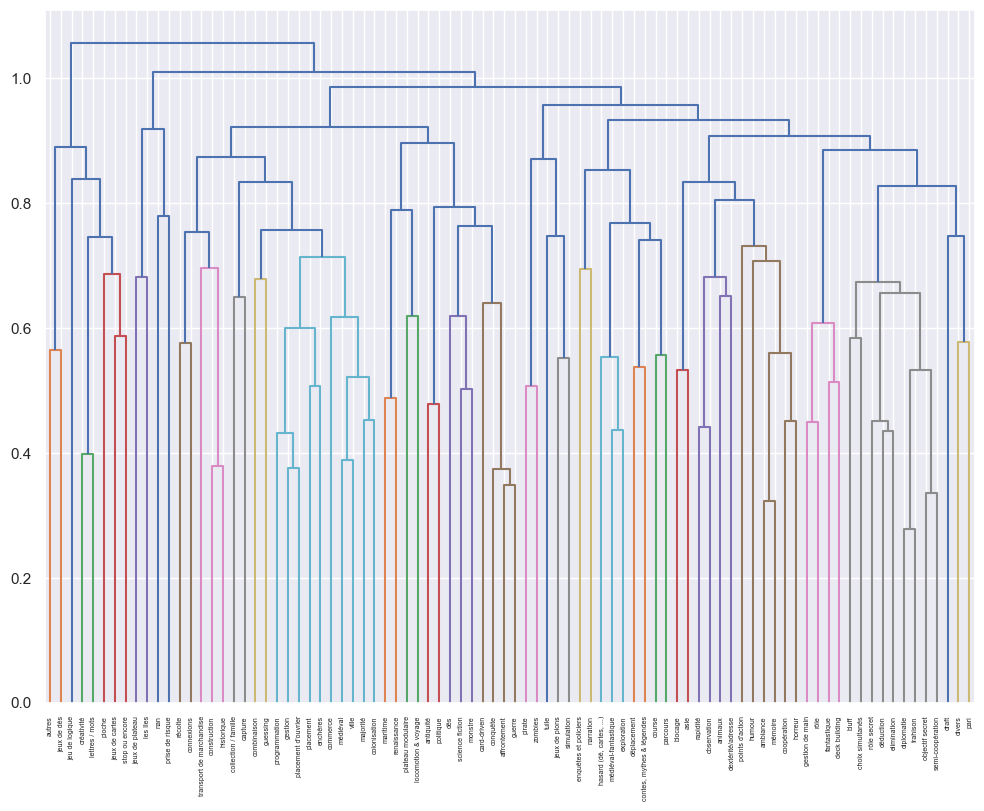

In [188]:
linkage_matrix=linkage(games_proj,method='average', metric="correlation")

fig = plt.figure(figsize=(12,9))
dendrogram(linkage_matrix, labels=games_proj.index, leaf_rotation=90)
fig.savefig('myimage.svg', format='svg', dpi=1200)

In [189]:
clusters = fcluster(linkage_matrix, 0.78, "distance")
tags_clusters = pd.DataFrame(data={"Type":games_tags.columns.to_numpy(), "Cluster":clusters})
tags_clusters.groupby("Cluster").agg({"Type":list})

#score = silhouette_score(games_tags, clusters, metric="euclidean")
#print(f"Silhouette Score: {score}", np.unique(clusters).size)
tags_clusters.groupby("Cluster").count().sort_values("Type", ascending=False), np.unique(clusters).size

(         Type
 Cluster      
 8          12
 21          9
 12          7
 16          7
 19          6
 2           5
 6           5
 20          4
 18          4
 14          3
 22          3
 11          2
 13          2
 10          2
 15          2
 9           2
 17          2
 7           2
 4           2
 1           2
 5           1
 3           1,
 22)

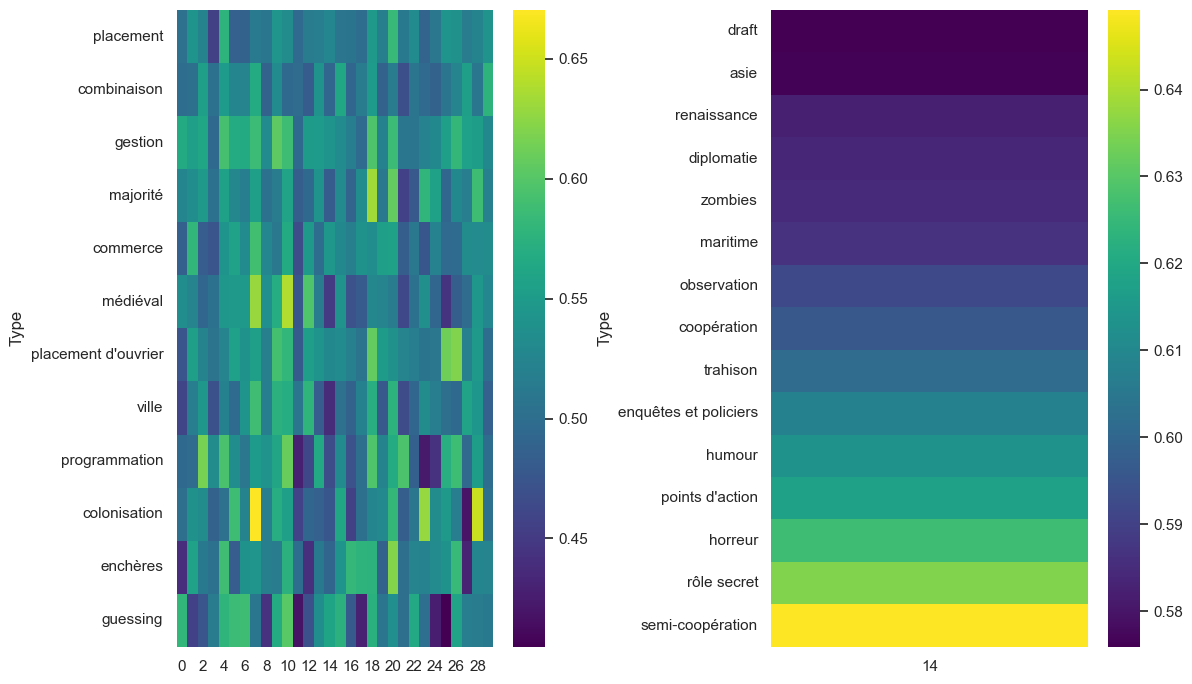

In [289]:
CLUSTER = 8
sns.set_theme(rc={"figure.figsize" : (12, 7)})

sel_types = tags_clusters[tags_clusters["Cluster"] == CLUSTER]["Type"].values
#sel_tags = games_proj.loc[["médiéval-fantastique", "fantastique"], :]
sel_tags = games_proj.loc[sel_types, :]
    

#sns.heatmap(games_proj.loc[:, [CLUSTER]].sort_values(by=CLUSTER).tail(25), cmap="viridis")
#sel_tags = games_proj.loc[sel_types, :]
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.heatmap(sel_tags, cmap="viridis", ax=ax1, cbar=True)
COMPONENT = 14
sns.heatmap(games_proj.loc[:, [COMPONENT]].sort_values(by=COMPONENT).tail(15), cmap="viridis", ax=ax2, cbar=True)
plt.tight_layout()

| Cluster | Common theme |
| ------- | ------------ |
| 8 | Jeux qui basé sur la commerce, gestion, époque médieval |
| 21 | Bluff, rôle secret, sémi-coopération |
| 12 | Affrontement, conflit, compétition |
| 16 | Fantastique |
| 19 | Immersive, coopération |
| 2 | Gestion, économie |
---

| Component | Meaning |
| --------  | ------- |
| 0 | Deck building |
| 1 | Gesion, commerce **non rapide**|
| 2 | Card-driven, draft |
| 3 | Antiquité, fantastique |
| 4 | Autres |
| 5 | Capture |
| 6 | Historique avec des cartes |
| 7 | Colonisaton dans rennaissance ou médieval -> contrôl des ressources |
| 8 | Exploration, gestion stratégique des ressources (en rennaissance) |
| 9 | Science-fiction |
| 10 | Compétitif (en médieval) |
| 11 | Lore riche + horreur | 
| 12 | Manipulation |
| 13 | Gestion des ressources + mouvement |
| 14 | Sémi-coopération, role secret, horreur | 
| 15 | enquêtes & policiers |
| 16 | Blocage -> compétition|
| 17 | Horreur | 
| 18 | Capture |
| 19 | Maritime, logique et créativité |
| 20 | Tranport de marchandise, gestion des ressources (historique) |
| 21 | zombies |
| 22 | sémi-coopération |
| 23 | draft (cartes) |
| 24 | Tranport  de marchandise, gestion des ressources (historique) |
| 25 | monstre + maritime |
| 26 | déplacement ?
| 27 | draft |
| 28 | sémi-coopération trahison en rennaissance |
| 29 | rôle secret |

([<matplotlib.lines.Line2D at 0x303725c10>],
 array([16, 17, 21, 19, 24, 18, 20, 23, 22, 13, 14, 15, 10,  9, 11,  8,  0,
         7,  5, 12,  1,  4,  2,  3,  6]))

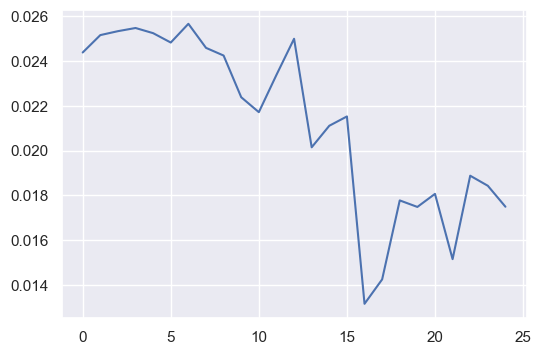

In [275]:
sns.set_theme(rc={"figure.figsize":(6, 4)})
scores = []
for n in range(5, 30):
    kmeans = KMeans(n_clusters=n, random_state=42) 
    kmeans.fit(U) 
    scores.append(silhouette_score(U, kmeans.labels_))

plt.plot(scores), np.argsort(scores)

In [281]:
kmeans_users = KMeans(n_clusters=6, random_state=42).fit(U)
users_labels = kmeans.labels_ 

Text(0.5, 1.0, 'Users centroids on latent factors')

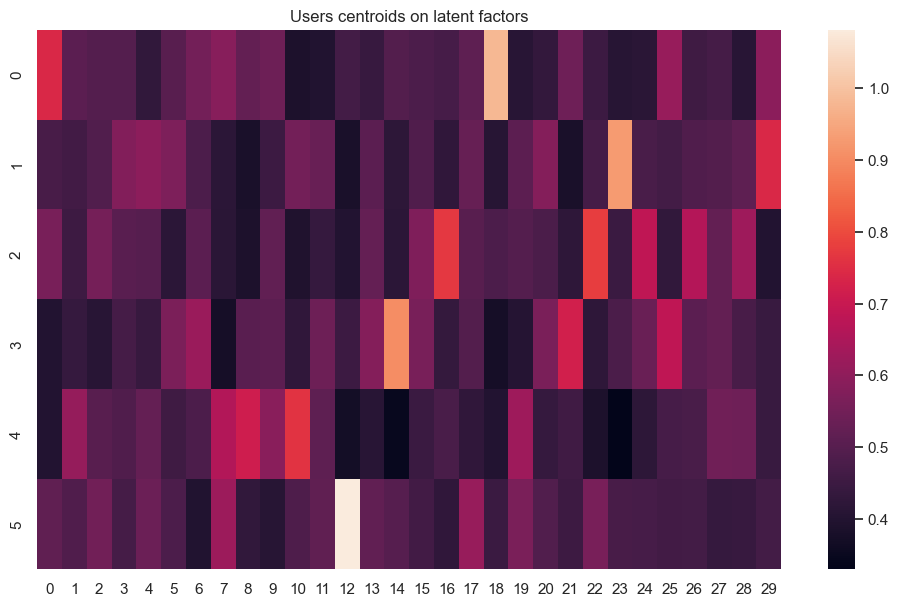

In [290]:
ax = sns.heatmap(kmeans_users.cluster_centers_)
ax.set_title("Users centroids on latent factors")

<Axes: xlabel='Cluster', ylabel='Count'>

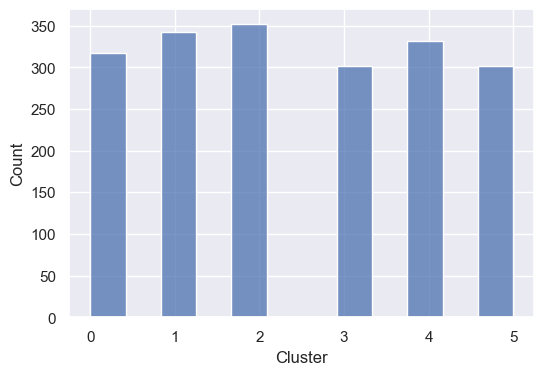

In [287]:
users_clusters = pd.DataFrame(data={"User id":users_ids, "Cluster":kmeans_users.labels_})
sns.histplot(users_clusters["Cluster"])

In [ ]:
clusters_users_tags = users_clusters.pivot_table(index="User id", columns="Cluster", aggfunc='size', fill_value=0).T 
#clusters_users_tags_normal = clusters_tags / clusters_tags.sum(axis=0) # normalize
#sns.heatmap(clusters_tags_normal)


array([ True,  True,  True, ..., False, False, False])

In [ ]:
clusters_tags = users_clusters.pivot_table(index="Game id", columns="Cluster", aggfunc='size', fill_value=0).T @ games_tags
clusters_tags_normal = clusters_tags / clusters_tags.sum(axis=0) # normalize
sns.heatmap(clusters_tags_normal)